In [2]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from astropy.wcs import WCS
import pandas as pd
import seaborn as sns

os.chdir('/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns')
from isochrone_preprocessing_fns import *
from photmetry_catalog_preprocessing_fn import *
from plotting_fns import *

# Compute Dust attenuation

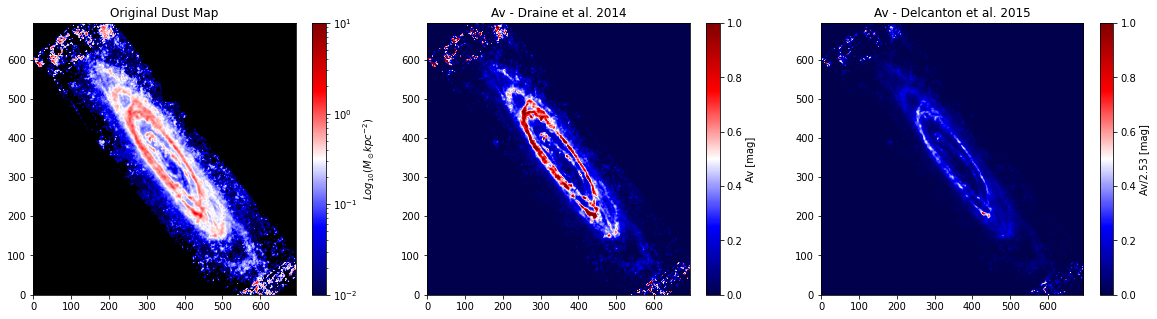

In [66]:
# Use dust mass surface density map to derive the extinction Av - Draine et al. 2014
dust_mass_density_hdu = fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Mdust.fits')
dust_mass_density_map = dust_mass_density_hdu[0].data # M_sun/kpc^2

# convert dust map to M_sun/pc^2
cos_i = 0.213
dust_mass_density_map = dust_mass_density_map*cos_i # *1e6 # M_sun/pc^2

# Apply extinction-dust mass surface density ratio to derive the extinction Av
# Draine et al. 2014
# Av_emission_map =  7.394 * dust_mass_density_map # Av
Av_emission_map = 0.74 * (dust_mass_density_map /  1e5)
# Apply scaling factor from Delcanton et al. 2015
Av_emission_map_d15 = Av_emission_map / 2.53

# Plot the extinction maps
fig, ax = plt.subplots(1,3, figsize=(20,5))
cmap = plt.cm.seismic
cmap.set_bad(color='black')
im = ax[0].imshow(Av_emission_map, cmap=cmap, aspect='auto', norm=colors.LogNorm(vmin=0.01, vmax=10), origin='lower')
ax[0].set_title('Original Dust Map')
fig.colorbar(im, ax=ax[0], label=r'$Log_{10} (M_\odot kpc^{-2})$') 

im = ax[1].imshow(Av_emission_map, cmap=cmap, aspect='auto', norm=colors.Normalize(vmin=0.0, vmax=1), origin='lower')
ax[1].set_title('Av - Draine et al. 2014')
fig.colorbar(im, ax=ax[1], label='Av [mag]')

im = ax[2].imshow(Av_emission_map_d15, cmap=cmap, aspect='auto', norm=colors.Normalize(vmin=0.0, vmax=1), origin='lower')
ax[2].set_title('Av - Delcanton et al. 2015')
fig.colorbar(im, ax=ax[2], label='Av/2.53 [mag]')
plt.show()

In [62]:
Av_emission_map.max()

51.683598

In [5]:
dust_mass_density_hdu[0].header['*']

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                  -32 /bits per data value                             
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                  694 /                                                
NAXIS2  =                  694 /                                                
EXTEND  =                    T /file may contain extensions                     
CTYPE1  = 'RA---TAN'           /                                                
CTYPE2  = 'DEC--TAN'           /                                                
EQUINOX =              2000.00 /                                                
CD1_1   =          -0.00500000 /                                                
CD2_2   =           0.00500000 /                                                
CD1_2   =              0.00000 /                                                
CD2_1   =              0.000

# Testing Projection transformation after binning

In [2]:
# Open fits file
dust_lum_hdu = fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Ldust.fits')

In [3]:
dust_lum_hdu[0].header['*']

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                  -32 /bits per data value                             
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                  694 /                                                
NAXIS2  =                  694 /                                                
EXTEND  =                    T /file may contain extensions                     
CTYPE1  = 'RA---TAN'           /                                                
CTYPE2  = 'DEC--TAN'           /                                                
EQUINOX =              2000.00 /                                                
CD1_1   =          -0.00500000 /                                                
CD2_2   =           0.00500000 /                                                
CD1_2   =              0.00000 /                                                
CD2_1   =              0.000

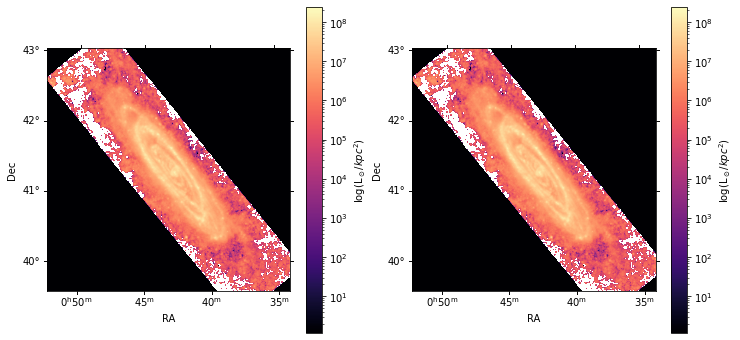

In [4]:
wcs = WCS(dust_lum_hdu[0].header)
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': wcs})

# Display the image on each subplot
axs[0].imshow(dust_lum_hdu[0].data, cmap='magma', norm=colors.LogNorm())
axs[1].imshow(dust_lum_hdu[0].data, cmap='magma', norm=colors.LogNorm())

# Set labels for each subplot
axs[0].set_xlabel('RA')
axs[0].set_ylabel('Dec')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('Dec')

# Add colorbars to each subplot
cbar1 = fig.colorbar(axs[0].images[0], ax=axs[0], label=r'log(L$_\odot/kpc^2$)')
cbar2 = fig.colorbar(axs[1].images[0], ax=axs[1], label=r'log(L$_\odot/kpc^2$)')

plt.show()


In [5]:
image_data = dust_lum_hdu[0].data

# Get the shape of the image
image_shape = image_data.shape

# Create empty lists to store the RA, Dec, and color values
ra_values = []
dec_values = []
color_values = []

# Loop through each pixel in the image
for i in range(image_shape[0]):
    for j in range(image_shape[1]):
        # Convert pixel coordinates to RA and Dec
        ra, dec = wcs.all_pix2world(j, i, 0)
        
        # Append the RA, Dec, and color value to the respective lists
        ra_values.append(ra)
        dec_values.append(dec)
        color_values.append(image_data[i, j])

# Create the dataframe
df = pd.DataFrame({'ra': ra_values, 'dec': dec_values, 'dust_lum_kpc2': color_values})
ra = df['ra'].values
dec = df['dec'].values
values = df['dust_lum_kpc2'].values
bin_size_deg = 0.01 # square degree
min_ra, max_ra, min_dec, max_dec, median_values, sum_values, bin_counts_nonzero = create_spatial_bins_and_median_optimized(ra, dec, values, bin_size_deg)

# # Save medina values to fits file
# hdu = fits.PrimaryHDU(median_values.T)
# hdu.writeto('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Ldust_median_values.fits', overwrite=True)

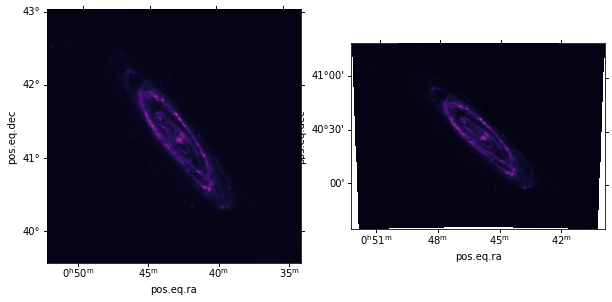

In [7]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

# Load the first FITS file
hdul1 = fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Ldust.fits')

# Extract WCS information from the first FITS file
wcs1 = WCS(hdul1[0].header)

# Load the second FITS file
hdul2 = fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Ldust_median_values.fits')

# Extract WCS information from the second FITS file
wcs2 = WCS(hdul2[0].header)

# Create a new figure and two subplots with different WCS
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection=wcs1)
ax2 = fig.add_subplot(1, 2, 2, projection=wcs2)

# Display the images
ax1.imshow(hdul1[0].data, origin='lower', cmap='magma')
ax2.imshow(hdul2[0].data, origin='lower', cmap='magma')

plt.show()

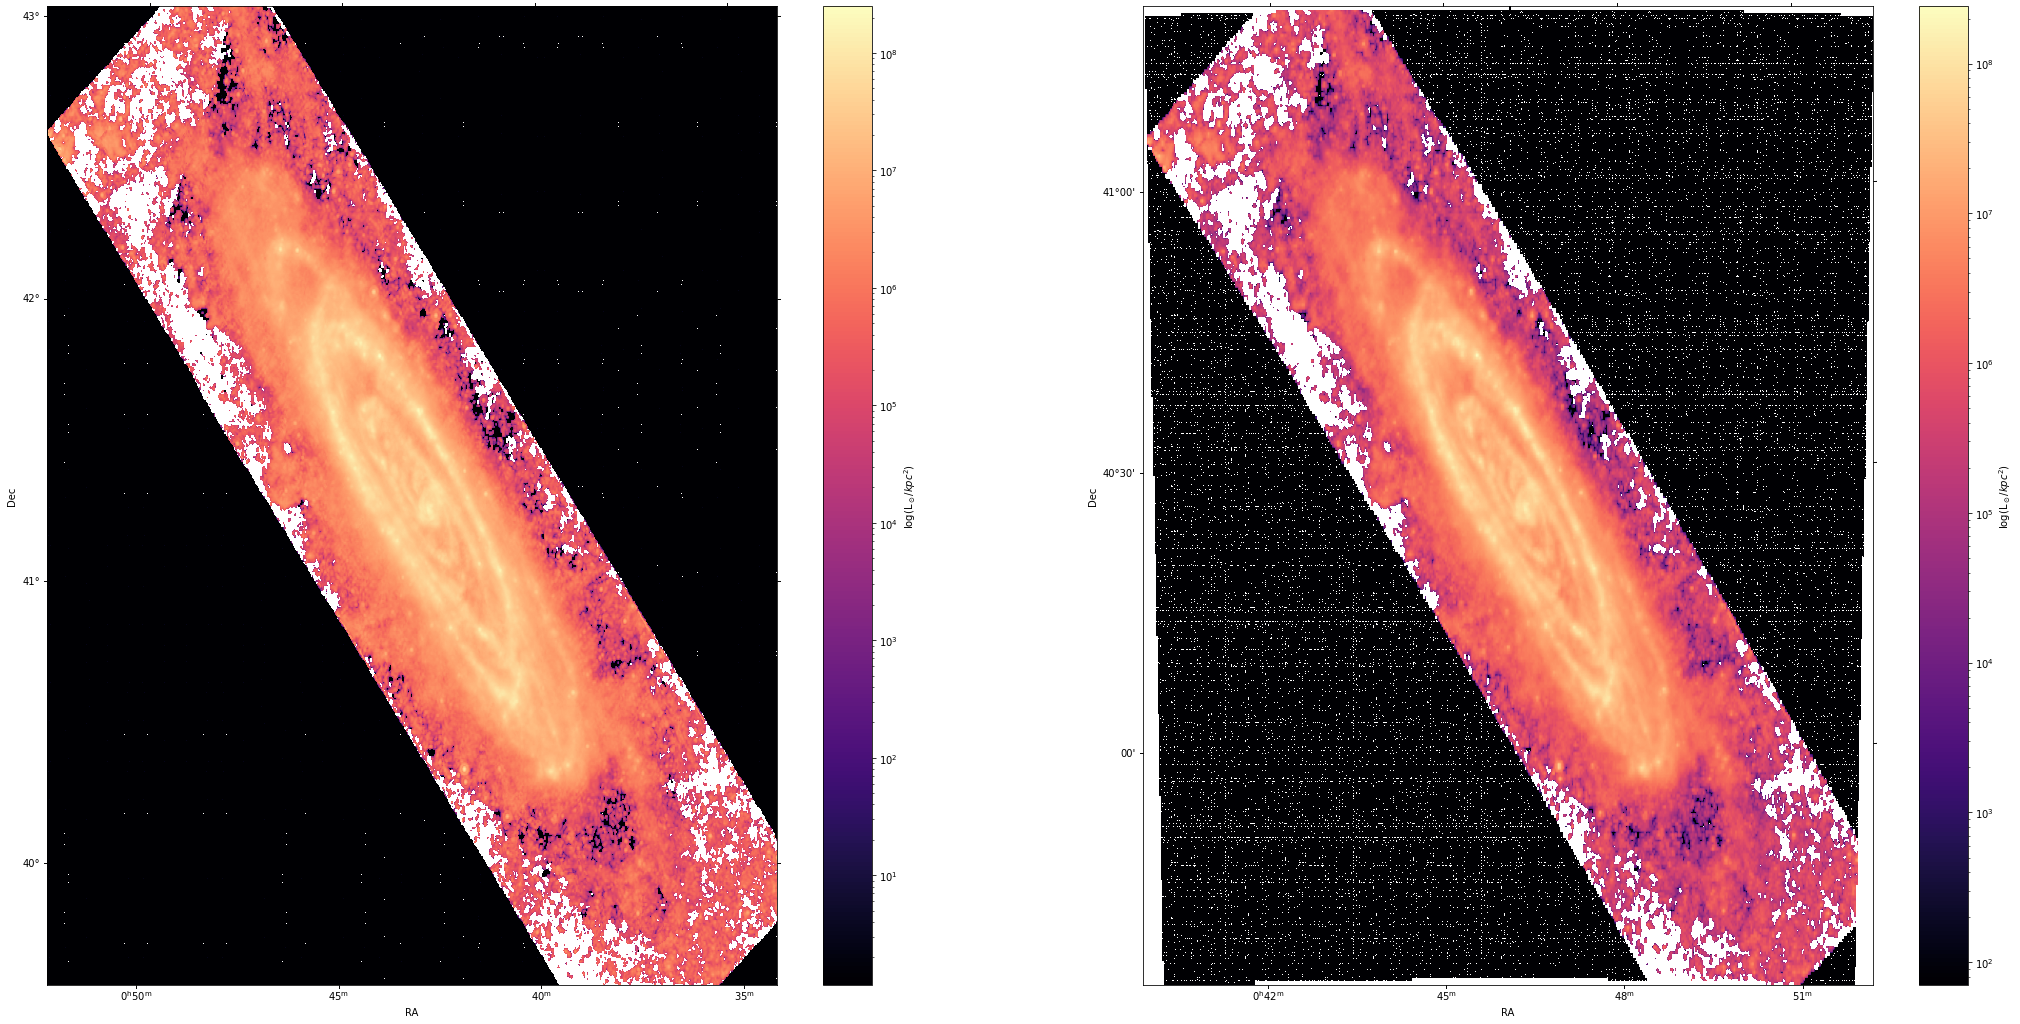

In [6]:
wcs = WCS(dust_lum_hdu[0].header)
fig, axs = plt.subplots(1, 2, figsize=(36, 18), subplot_kw={'projection': wcs})

# Display the image on each subplot
axs[0].imshow(dust_lum_hdu[0].data, cmap='magma', norm=colors.LogNorm(), aspect='auto')
axs[1].imshow(median_values.T, cmap='magma', norm=colors.LogNorm(), aspect='auto')

# Set labels for each subplot
axs[0].set_xlabel('RA')
axs[0].set_ylabel('Dec')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('Dec')
axs[1].invert_xaxis()

# Add colorbars to each subplot
cbar1 = fig.colorbar(axs[0].images[0], ax=axs[0], label=r'log(L$_\odot/kpc^2$)')
cbar2 = fig.colorbar(axs[1].images[0], ax=axs[1], label=r'log(L$_\odot/kpc^2$)')

plt.show()


In [10]:
wcs.wcs.cdelt

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_82824/1917255867.py:1: RuntimeWarning: cdelt will be ignored since cd is present
  wcs.wcs.cdelt


array([1., 1.])

### Binning Dust Map using astropy

In [16]:
from astropy.io import fits
from astropy.wcs import WCS

# Load the FITS file
hdul = fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Ldust.fits')

# Extract WCS information
wcs = WCS(hdul[0].header)

# Define the bin size in square degrees
bin_size_deg2 = 0.01  # square degrees

# Adjust WCS pixel scales
wcs.wcs.cdelt *= bin_size_deg2 ** 0.5

# Update FITS header with new WCS information
hdul[0].header.update(wcs.to_header())
# Create a new HDU with the median values
hdu_median = fits.PrimaryHDU(median_values.T)

# Replace the existing image in the HDU list with the new HDU
hdul[0] = hdu_median

# Save the FITS file with updated median values
hdul.writeto('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Ldust_median_values.fits', overwrite=True)

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_82824/229458914.py:14: RuntimeWarning: cdelt will be ignored since cd is present
  wcs.wcs.cdelt *= bin_size_deg2 ** 0.5


In [17]:
from astropy.io import fits
from astropy.wcs import WCS

# Load the FITS file
hdul = fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Ldust.fits')

# Extract WCS information
wcs = WCS(hdul[0].header)

# Define the bin size in square degrees
bin_size_deg2 = 0.01  # square degrees

# Adjust WCS pixel scales
wcs.wcs.cdelt *= bin_size_deg2 ** 0.5

# Create a new HDU with the binned data
hdu = fits.PrimaryHDU(median_values.T[:,::-1])

# Update the header of the new HDU with the WCS information
hdu.header.update(wcs.to_header())

# Create a new HDU list with the new HDU
hdul_binned = fits.HDUList([hdu])

# Write the new HDU list to a FITS file
hdul_binned.writeto('/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_M160_111_SSS_111_Model_All_SurfBr_Ldust_median_values.fits', overwrite=True)

/var/folders/41/1_71sw_13ql14yq5j387scf80000gn/T/ipykernel_82824/365892797.py:14: RuntimeWarning: cdelt will be ignored since cd is present
  wcs.wcs.cdelt *= bin_size_deg2 ** 0.5


In [6]:
df.head()

,ra,dec,dust_lum_kpc2
0,13.042566310695225,39.57128171350071,0.0
1,13.036090754120888,39.57140661164111,0.0
2,13.029615140135888,39.5715311510526,0.0
3,13.02313946890488,39.571655331724784,0.0
4,13.016663740592557,39.57177915364722,0.0


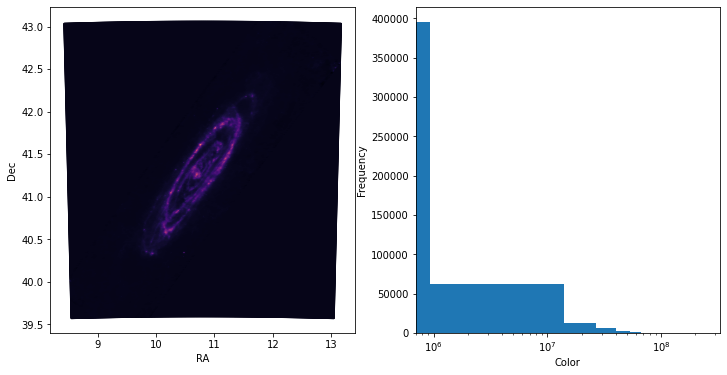

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatterplot of RA and Dec
ax1.scatter(df['ra'], df['dec'], s=1, c=df['dust_lum_kpc2'], cmap='magma')
ax1.set_xlabel('RA')
ax1.set_ylabel('Dec')

# Histogram of color
ax2.hist(df['dust_lum_kpc2'], bins=20)
ax2.set_xlabel('Color')
ax2.set_ylabel('Frequency')
ax2.set_xscale('log')

plt.show()


### Bin the dust map

TypeError: 'numpy.float64' object is not iterable

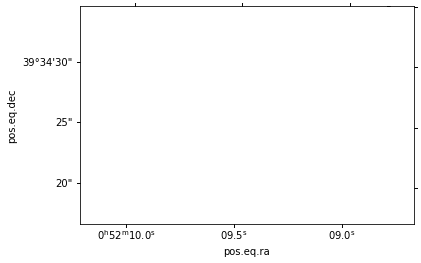

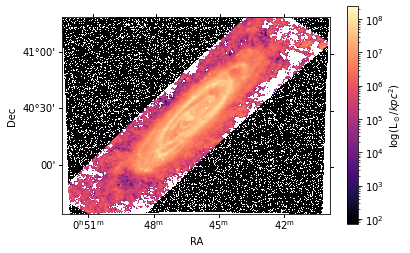

In [ ]:
ra = df['ra'].values
dec = df['dec'].values
values = df['dust_lum_kpc2'].values
bin_size_deg = 0.01
min_ra, max_ra, min_dec, max_dec, median_values, sum_values, bin_counts_nonzero = create_spatial_bins_and_median_optimized(ra, dec, values, bin_size_deg)

# from wcsaxes import WCS
wcs = WCS(dust_lum_hdu[0].header)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=wcs)

# Display the image
dust_lum_map = plt.imshow(median_values.T, cmap='magma', norm=colors.LogNorm())

# Set labels
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(dust_lum_map, label=r'log(L$_\odot/kpc^2$)')
plt.show()

In [9]:
# Get the WCS object from the dust_lum_hdu
wcs = WCS(dust_lum_hdu[0].header)

# Project the RA and Dec values after binning
bin_ra, bin_dec = wcs.all_world2pix(min_ra, min_dec, 0)

(array(711.8642443), 8.428160791405922)

In [8]:
# # Define the bin size
# bin_size = 0.01

# # Bin the data by RA and Dec
# df['RA_bin'] = pd.cut(df['RA'], bins=np.arange(df['RA'].min(), df['RA'].max() + bin_size, bin_size))
# df['Dec_bin'] = pd.cut(df['Dec'], bins=np.arange(df['Dec'].min(), df['Dec'].max() + bin_size, bin_size))

# Using the F275W filter to remove dusty regions from the M31 galaxy

In [2]:
phast_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv')
print(len(phast_df))
phast_df.columns

76662566


Index(['Unnamed: 0', 'ra', 'dec', 'f475w_vega', 'f475w_snr', 'f475w_crowd',
       'f475w_sharp', 'f475w_flag', 'f814w_vega', 'f814w_snr', 'f814w_crowd',
       'f814w_sharp', 'f814w_flag', 'f275w_vega', 'f275w_snr', 'f275w_crowd',
       'f275w_sharp', 'f275w_flag'],
      dtype='object')

In [ ]:
phast_df_f275w_gst = phast_df[phast_df['f275w_flag'] != 0]


# Plot stellar density, F275 magnitude

In [48]:
ra = phast_df['ra'].values
dec = phast_df['dec'].values
values = phast_df['f275w_flag'].values
bin_size_deg = 0.01
min_ra, max_ra, min_dec, max_dec, median_values, sum_values, bin_counts_nonzero = create_spatial_bins_and_median_optimized(ra, dec, values, bin_size_deg)



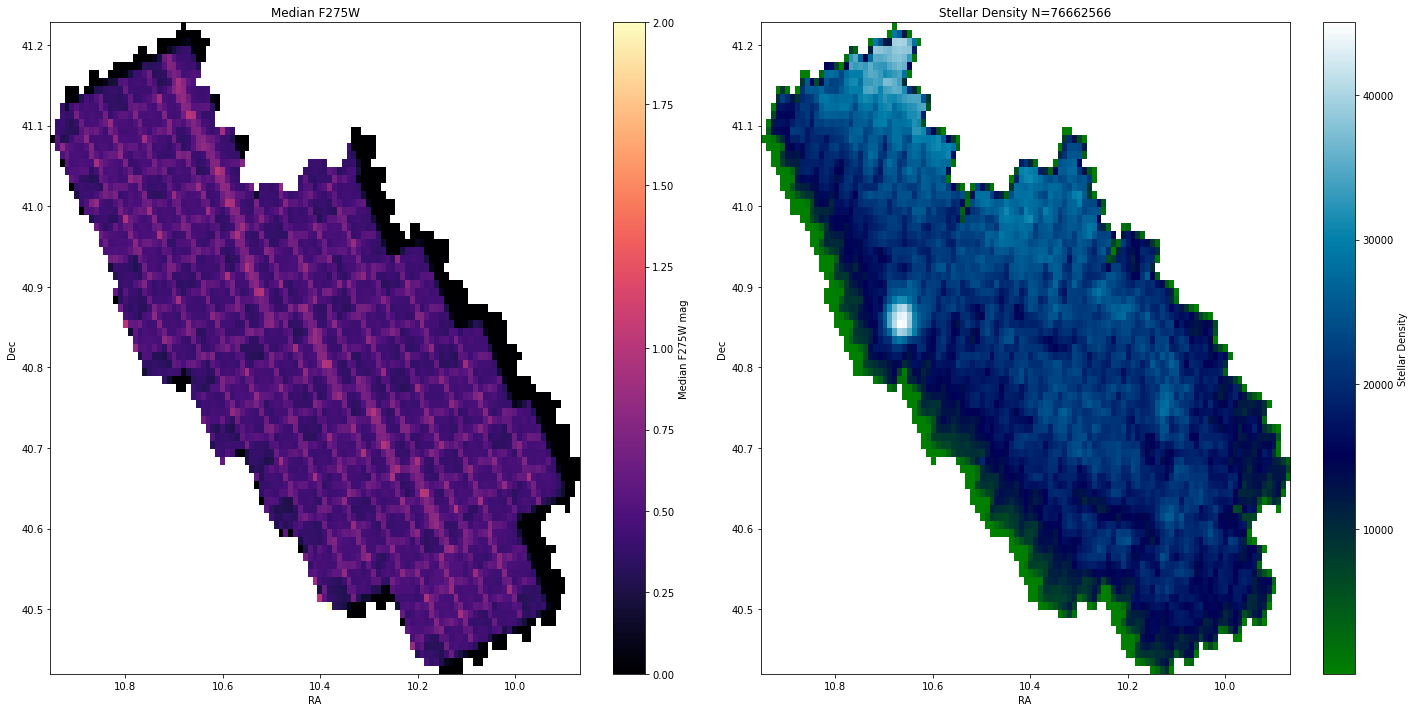

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot the median values
axs[0].imshow(median_values.T, cmap='magma', aspect='auto', extent=[min_ra, max_ra, min_dec, max_dec], origin='lower',)
axs[0].set_xlabel('RA')
axs[0].set_ylabel('Dec')
axs[0].set_title('Median F275W')
axs[0].invert_xaxis()
cbar = fig.colorbar(axs[0].images[0], ax=axs[0], label='Median F275W mag')

# Stellar Density
axs[1].imshow(bin_counts_nonzero.T, cmap='ocean', aspect='auto', extent=[min_ra, max_ra, min_dec, max_dec], origin='lower')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('Dec')
axs[1].set_title(f'Stellar Density N={len(phast_df)}')
axs[1].invert_xaxis()
cbar = fig.colorbar(axs[1].images[0], ax=axs[1], label='Stellar Density')

plt.tight_layout()
plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/phast_F275W_gst_and_stellar_density.jpeg')
plt.show()

In [3]:
# interpolated values
interp_phast_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phast_MH_catalog.csv')
print(len(interp_phast_df))
interp_phast_df.columns

2722981


Index(['Unnamed: 0', 'ra', 'dec', 'f475w_vega', 'f475w_snr', 'f475w_crowd',
       'f475w_sharp', 'f475w_flag', 'f814w_vega', 'f814w_snr', 'f814w_crowd',
       'f814w_sharp', 'f814w_flag', 'f814w_vega_ecorr', 'f475w_vega_ecorr',
       'f475w-f814w_ecorr', 'f475w-f814w_vega', 'f475w_vega-f814w_vega',
       'interpolated_MH', 'interpolated_Mini', 'interpolated_int_IMF',
       'interpolated_Mass', 'interpolated_logL', 'interpolated_logTe',
       'interpolated_logg'],
      dtype='object')

In [ ]:
# Drop F275W GST = 1
phast_df_f275w_gst = phast_df[phast_df['f275w_flag'] != 0]
